## 第15章　LSTMで過去を記憶する

前章まででは、ディープラーニングモデルを構築し、線形ニューラルネットワークモデルとディープニューラルネットワーク（DNN）モデルを実装した。

本章では、**リカレントニューラルネットワーク**（**RNN**）の一形態である**長短期記憶**（**LSTM**）を調べる。

## 15.1　リカレントニューラルネットワーク（RNN）を探索する

**リカレントニューラルネットワーク(Recurrent Neural Network:RNN)**

　データシーケンスの処理に適したディープラーニングアーキテクチャ。「順序」が重要なデータに向いている。

　RNNはネットワークに入力として戻される隠れ状態を使うため、シーケンスの次の要素を処理するときに過去の情報を入力として使うことができる。現在の入力と過去の状態をもとに情報を更新し、系列データの”文脈”や”記憶”を保持する。

　　$h_t = tanh(W_xx_t + W_hh_{t-1} +b)$

　ただ、RNNは短期記憶の問題がある。遠い過去の情報は影響力を持たなくなる。　→　LSTMやGPUの開発

　自然言語処理などに応用されている。

<img src="IMG_6083.jpg">

<img src="IMG_6084.jpg">

**BPTT(Back Propagation Through Time)**

時間方向に展開されたRNN構造に対して、通常の誤差逆伝播を”時間に遡って”行う手法。

　　$\frac{\partial}{\partial h_s} MSE = \frac{\partial h_{s+1}}{\partial h_s} \frac{\partial}{\partial h_{s+1}} MSE$ 
$  \to  $
$\frac{\partial}{\partial h_s} \mathrm{MSE}
= \left( \prod_{u=s}^{t-1} \frac{\partial h_{u+1}}{\partial h_u} \right)
\cdot \frac{\partial}{\partial h_t} \mathrm{MSE}$

$\left( \prod_{u=s}^{t-1} \frac{\partial h_{u+1}}{\partial h_u} \right) \cdot $は過去になればなるほど小さくなる。　$\to$ 勾配消失

長い系列を通して、初期の入力や状態の影響が出力の学習に反映されなくなる。このため、長期依存関係の学習が困難。

## 15.2 LSTMアーキテクチャを調べる

**長短期記憶(Long Short-Term Memory:LSTM)**

　RNNのサブタイプであるディープラーニングアーキテクチャ。RNNにセル状態を追加したもの。　→ 勾配消失問題の回避につながる。
 
　セル状態を追加することで短期記憶の問題に対処する。過去の情報がより長い期間にわたってネットワークに流れるようになる。
 
　LSTMは次の３つのゲートかで構成される。
 
　　・忘却ゲート　：　過去ステップのどの情報がまだ妥当であるかを判断
  
　　・入力ゲート　：　現在ステップのどの情報が妥当であるかを判断
  
　　・出力ゲート　：　どの情報がシーケンスの次の要素に渡されるか、または結果として出力層に渡されるかを決定

$C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t$

　$C_t$：現在のセル状態　　$C_{t-1}$前のセル状態　　$f_t$：忘却ゲートの出力

　$i_t$：入力ゲートの出力　　$\tilde{C}_t$：新しい記憶候補

<img src="IMG_6092.jpg">

**忘却ゲート**

LSTMの最初のゲートでシーケンスの過去の値と現在の値の両方に対して、忘れるべき情報とネットワークに残しておくべき情報を判断する。

現在の要素と過去の情報を結合し、複製する。

一方は、そのまま次のゲート(入力ゲート)に渡される。

もう一方はSigmoid関数\sigma(x)を通過し、過去のセル状態と結合し、更新されたセル状態を生成する。

　　$f_t = \sigma \left( W_f \begin{bmatrix} h_{t-1} \\ x_t \end{bmatrix} + b_f \right)$

<img src="IMG_0370.jpg">

**入力ゲート**

シーケンスの現在の要素からの情報のうちどれが妥当であるかをネットワークが判断する。

忘却ゲートから送られてきた過去の隠れ状態とシーケンスの現在の要素の組み合わせが渡され、複製される。

１つ目のコピーは、次のゲート(出力ゲート)に向かう。

２つ目のコピーは、Sigmoid関数を通過し、情報を残すかを決定する。

３つ目のコピーは、tanh関数を通過し、計算を効率化するためにネットワークを調整する。

２つの演算の結果を点ごとの乗算を使って結合し、その結果をセル状態に加算し、情報を更新する。

　　$i_t = \sigma \left( W_i \begin{bmatrix} h_{t-1} \\ x_t \end{bmatrix} + b_i \right)$

　　$\tilde{C}_t = \tanh \left( W_c \begin{bmatrix} h_{t-1} \\ x_t \end{bmatrix} + b_c \right)$


<img src="IMG_0371.jpg">

**出力ゲート**

入力ゲートから送られてきた過去の隠れ状態とシーケンスの現在の要素が関数に渡される。

過去の情報(セル状態$C_t$)が関数に渡される。

これら２つの出力が点ごとの乗算を使って結合され、新たな隠れ層が出力される。

この新たな隠れ層をLSTMニューロンまたは、出力層に渡される。同時にセル状態も出力される。

　　$o_t = \sigma \left( W_o \begin{bmatrix} h_{t-1} \\ x_t \end{bmatrix} + b_o \right)$

<img src="IMG_0372.jpg">

## 15.3　LSTMアーキテクチャを実装する

In [35]:
import datetime
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras import layers,Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Flatten, Reshape,Dropout, BatchNormalization, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
from tensorflow.keras.layers import SimpleRNN
tf.random.set_seed(42)
np.random.seed(42)
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import importlib.util
import sys
# japanize-matplotlib が未インストールなら pip install
if importlib.util.find_spec("japanize_matplotlib") is None:
  !pip install japanize-matplotlib
# 必要なライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from CH13_14 import DataWindow,BaselineModel,model_predict,plot_model_prediction,compile_and_fit

# CH12のデータのロード from GitHubのrawデータURL
u1 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_train.csv"
u2 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_val.csv"
u3 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_test.csv"
# データの読み込み
train_df = pd.read_csv(u1)
val_df = pd.read_csv(u2)
test_df = pd.read_csv(u3)
train_df.head()

print(train_df.shape, val_df.shape, test_df.shape)
column_indices = {name: i for i, name in enumerate(train_df.columns)}
print(column_indices)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2.17.0
GPU Available: []
(12285, 5) (3510, 5) (1756, 5)
{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}


## CH.15 LSTM

### 15.3.1 Single Step Model

In [36]:
w = DataWindow(input_width=24,label_width=1,shift=1,stride=1,
    train_df=train_df,val_df=val_df,test_df=test_df,
    label_columns=['traffic_volume'])

In [37]:
val_performance= {'Full-DNN': (0.0019, 0.031),
  'RNN': (0.0016, 0.0283),
  'LSTM': (0.0014, 0.0265),
  'Simple Transformer': (0.0018, 0.0305)
  }
test_performance={'Full-DNN': (0.0015, 0.0281),
  'RNN': (0.0014, 0.0272),
  'LSTM': (0.0011, 0.0246),
  'Simple Transformer': (0.0015, 0.028)
  }

### Full DNN Model: Baseline Model

**Full DNNモデル**

時系列の構造を無視して、全データを一つのベクトルとして処理するDense型のニューラルネットワーク。

Flatten層によって、２次元入力を１次元入力に変換する。この操作により時間軸（時系列順）という構造的意味は失われる。

　　$(\vec{x}_1, \vec{x}_2,・・・,\vec{x}_t)  \overset{flatten}{\to}  \vec{X}_{1:t}  \overset{NN}{\to}  y_{t+1}$

　　$f_{relu}(\vec{X}_{1:t}W^{(1)} + \vec{b}^{(1)})W^{(2)} + b^{(2)} = y_{t+1}$

「周期性が強く、時間順依存性が弱い」データには有効　　→　　曜日別パターン等

**Full DNNの学習：勾配法**

損失関数（今回はMSE）の値・誤差が最小となるように重み$W^{(1)},W^{(2)}$などのパラメータを更新する。

　　$(y_{t+1} - {y_{t+1}^{True}})^2$  →　最小化

　　$\Deltaパラメータ = -\eta \frac{\partial}{\partialパラメータ} (y_{t+1} - {y_{t+1}^{True}})^2$

　　$\Delta(y_{t+1} - {y_{t+1}^{True}})^2 = \frac{\partial}{\partialパラメータ} (y_{t+1} - {y_{t+1}^{True}})^2$

　　　　　　　　       　$= -\eta (\frac{\partial}{\partialパラメータ} (y_{t+1} - {y_{t+1}^{True}})^2)^2$ < 0

誤差の減少量は勾配の二乗に比例する。また、勾配が０となる（＝消滅）と学習ができなくなる。

In [38]:
# データセットの input_shape を取得
input_shape = w.train.element_spec[0].shape[1:]  # 例：(24, 5)
label_width=w.label_width

full_dnn = Sequential([
    Flatten(input_shape=input_shape),      # [batch, 24, 5] → [batch, 120]
    Dense(32, activation='relu'),          # [batch, 120] → [batch, 32]
    Dense(label_width),  # [batch, 24]
    Reshape((label_width, 1))              # [batch, 24] → [batch, 24, 1]
])

#　モデルの訓練
history = compile_and_fit(full_dnn,w)

# 評価スコアを辞書に保存
val_performance={}
test_performance={}
val_loss, val_mae = full_dnn.evaluate(w.val, verbose=0)
test_loss, test_mae = full_dnn.evaluate(w.test, verbose=0)
val_performance["Full-DNN"] = (round(val_loss,4), round(val_mae,4))
test_performance["Full-DNN"] = (round(test_loss,4),round(test_mae,4))
val_performance,test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0576 - mean_absolute_error: 0.1667 - val_loss: 0.0097 - val_mean_absolute_error: 0.0717
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0657 - val_loss: 0.0056 - val_mean_absolute_error: 0.0535
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0058 - mean_absolute_error: 0.0554 - val_loss: 0.0050 - val_mean_absolute_error: 0.0516
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0046 - mean_absolute_error: 0.0489 - val_loss: 0.0043 - val_mean_absolute_error: 0.0495
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - mean_absolute_error: 0.0448 - val_loss: 0.0036 - val_mean_absolute_error: 0.0422
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0036 - mean_absolute_error: 0.0437 - val_loss: 0.0030 - val_mean_absolute_error: 0.0395
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0034 - mean_absolute_error: 0.0

({'Full-DNN': (0.002, 0.0315)}, {'Full-DNN': (0.0015, 0.0282)})

In [39]:
# input_shapeは DataWindow から取得した形 (例: (24, 5))
input_shape = w.train.element_spec[0].shape[1:]
label_width = w.label_width  # label_width は1など任意の予測ステップ数


simple_rnn = Sequential([
    SimpleRNN(units=32, input_shape=input_shape),
    Dense(units=label_width),
    Reshape((label_width, 1))
])

#　モデルの訓練
history = compile_and_fit(simple_rnn,w)

# 評価スコアを辞書に保存
val_loss, val_mae = simple_rnn.evaluate(w.val, verbose=0)
test_loss, test_mae = simple_rnn.evaluate(w.test, verbose=0)
val_performance["RNN"] = (round(val_loss,4), round(val_mae,4))
test_performance["RNN"] = (round(test_loss,4),round(test_mae,4))
val_performance,test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0799 - mean_absolute_error: 0.1802 - val_loss: 0.0087 - val_mean_absolute_error: 0.0693
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0078 - mean_absolute_error: 0.0652 - val_loss: 0.0058 - val_mean_absolute_error: 0.0572
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0052 - mean_absolute_error: 0.0529 - val_loss: 0.0041 - val_mean_absolute_error: 0.0472
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0478 - val_loss: 0.0034 - val_mean_absolute_error: 0.0425
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0458 - val_loss: 0.0036 - val_mean_absolute_error: 0.0435
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0037 - mean_absolute_error: 0.0437 - val_loss: 0.0036 - val_mean_absolute_error: 0.0459
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0

({'Full-DNN': (0.002, 0.0315), 'RNN': (0.0018, 0.0313)},
 {'Full-DNN': (0.0015, 0.0282), 'RNN': (0.0016, 0.0305)})

### LSTM Model

In [40]:
# input_shapeは DataWindow から取得した形 (例: (24, 5))
input_shape = w.train.element_spec[0].shape[1:]
label_width = w.label_width  # label_width は1など任意の予測ステップ数

lstm = Sequential([
    LSTM(32, input_shape=input_shape),
    Dense(label_width),
    Reshape((label_width, 1))
])

#　モデルの訓練
history = compile_and_fit(lstm,w)

# 評価スコアを辞書に保存
val_loss, val_mae = lstm.evaluate(w.val, verbose=0)
test_loss, test_mae = lstm.evaluate(w.test, verbose=0)
val_performance["LSTM"] = (round(val_loss,4), round(val_mae,4))
test_performance["LSTM"] = (round(test_loss,4),round(test_mae,4))
val_performance,test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0552 - mean_absolute_error: 0.1660 - val_loss: 0.0158 - val_mean_absolute_error: 0.0989
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0125 - mean_absolute_error: 0.0818 - val_loss: 0.0091 - val_mean_absolute_error: 0.0652
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - mean_absolute_error: 0.0584 - val_loss: 0.0055 - val_mean_absolute_error: 0.0524
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0495 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0424 - val_loss: 0.0031 - val_mean_absolute_error: 0.0414
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0403 - val_loss: 0.0035 - val_mean_absolute_error: 0.0428
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0

({'Full-DNN': (0.002, 0.0315),
  'RNN': (0.0018, 0.0313),
  'LSTM': (0.0015, 0.0279)},
 {'Full-DNN': (0.0015, 0.0282),
  'RNN': (0.0016, 0.0305),
  'LSTM': (0.0013, 0.0259)})

## TransformerとAttention

### Transformer Model

**Transformer**

Transformerとは、ChatGPTなどの大規模言語モデル（LLM）を支える最も重要な技術。

再帰や畳み込みを完全に排除し、アテンション機構にのみ基づいている。

**Transformerの本質**

１．再帰しない　→　すべての情報を一気に見る。（未来の情報には、”マスク”をかぶせる）

　　　　　　　　　　順序が重要なデータを順に処理するのではなく、全時点の関係を見る。

２．Self-Attention　→　Transformerモデル自身が重み付けをする。

３．並列化できるので学習が速く、長期の依存性を見逃さない。

In [41]:
# input_shapeは DataWindow から取得した形 (例: (24, 5))
input_shape = w.train.element_spec[0].shape[1:]
label_width = w.label_width  # label_width は1など任意の予測ステップ数

from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention

def build_simple_transformer(input_shape, label_width):
    inputs = tf.keras.Input(shape=input_shape)  # (input_width, features)

    # Denseで埋め込み (simple embedding)
    x = layers.Dense(32)(inputs)

    # Self-Attention (各時刻間で相互作用）
    x = MultiHeadAttention(num_heads=2, key_dim=16,name="self_attention")(x, x)

    # FlattenしてDenseへ（direct multi-step予測）
    x = layers.Flatten()(x)
    x = layers.Dense(label_width)(x)
    outputs = layers.Reshape((label_width, 1))(x)

    return tf.keras.Model(inputs, outputs)

# Transformer モデル構築
transformer_model = build_simple_transformer(input_shape=input_shape, label_width=label_width)

#　モデルの訓練
history = compile_and_fit(transformer_model,w)

# 評価スコアを辞書に保存
val_loss, val_mae = transformer_model.evaluate(w.val, verbose=0)
test_loss, test_mae = transformer_model.evaluate(w.test, verbose=0)
val_performance["Simple Transformer"] = (round(val_loss,4), round(val_mae,4))
test_performance["Simple Transformer"] = (round(test_loss,4),round(test_mae,4))
val_performance,test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0631 - mean_absolute_error: 0.1929 - val_loss: 0.0077 - val_mean_absolute_error: 0.0620
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0588 - val_loss: 0.0037 - val_mean_absolute_error: 0.0451
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046 - mean_absolute_error: 0.0483 - val_loss: 0.0030 - val_mean_absolute_error: 0.0402
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - mean_absolute_error: 0.0446 - val_loss: 0.0035 - val_mean_absolute_error: 0.0448
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0434 - val_loss: 0.0026 - val_mean_absolute_error: 0.0380
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0409 - val_loss: 0.0026 - val_mean_absolute_error: 0.0371
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0

({'Full-DNN': (0.002, 0.0315),
  'RNN': (0.0018, 0.0313),
  'LSTM': (0.0015, 0.0279),
  'Simple Transformer': (0.0017, 0.0297)},
 {'Full-DNN': (0.0015, 0.0282),
  'RNN': (0.0016, 0.0305),
  'LSTM': (0.0013, 0.0259),
  'Simple Transformer': (0.0014, 0.0277)})

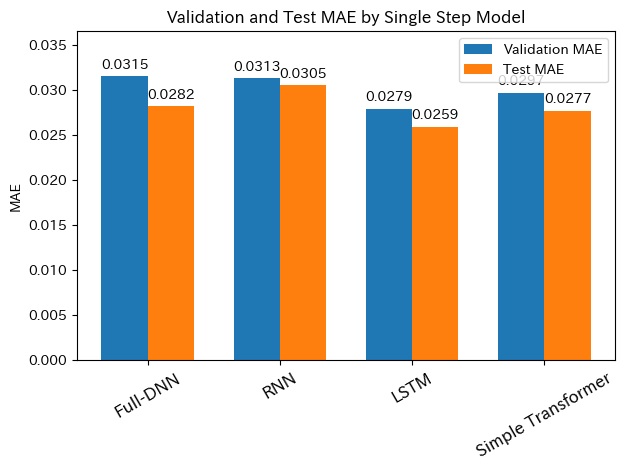

In [42]:
# MAE（1番目の指標）を抽出
labels = list(val_performance.keys())
val_mae = [val_performance[k][1] for k in labels]
test_mae = [test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
val_bars = ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
test_bars = ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

# 数値ラベルの追加
for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 追加：Y軸の上限を調整して重なりを防ぐ
max_val = max(max(val_mae), max(test_mae))
ax.set_ylim(0, max_val + 0.005)

# 軸・凡例設定
ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Single Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.legend()
plt.tight_layout()
plt.show()


### Attention Network

**Attention**

入力の中で”どこに注目すべきか”をモデルが自動で学習する仕組み

次の３つのベクトルを使う。

　・Query（Q）：「今注目したいもの」を表すベクトル

　・Key（K）：「どこに何が書かれているか」を表すベクトル

　・Value（V）：実際に取り出す情報そのもの

**Attentionの仕組み**

上のQ,K,Vは、Dense層によって決定されたQ,K,Vそれぞれの重み行列と入力ベクトルによって生成される。

　　$Q_t = \vec{x}_t^T W_Q$

　　$K_t = \vec{x}_t^T W_K$

　　$V_t = \vec{x}_t^T W_V$

　　$H = d_v = d_k \times$ num_heads

その後、

　　１．クエリとすべてのキーの内積を計算

　　２．それぞれの内積を$\sqrt{d_k}$で割る。（スケーリング） ここで、用いる$\sqrt{d_k}$はクエリ及びキーの次元

　　３．結果に関数を適用し、バリューに対する重みを得る。

　　　$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left( \frac{Q K^\top}{\sqrt{d_k}} \right) V$

**Self-Attention**

各時点のデータが、系列中の他のすべての時点の「重み付けして参照」する仕組み

　　→時系列等の長期依存関係を学習できる。

Q,K,Vが同一の系列に存在

In [43]:
def build_simple_transformer_with_attention(input_shape, label_width):
    inputs = tf.keras.Input(shape=input_shape)  # (input_width, features)

    x = layers.Dense(32)(inputs)

    # Self-Attention（スコアは呼び出し時に返す）
    attn_layer = layers.MultiHeadAttention(
        num_heads=2,
        key_dim=16,
        name="self_attention"
    )
    attn_output, attn_scores = attn_layer(x, x, return_attention_scores=True)

    x = layers.Flatten()(attn_output)
    x = layers.Dense(label_width)(x)
    preds = layers.Reshape((label_width, 1))(x)

    # attentionスコアと予測値を返す2出力モデル
    return tf.keras.Model(inputs=inputs, outputs=[preds, attn_scores])


In [44]:
def compile_and_fit_for_attention_model(model, window, patience=5, max_epochs=100):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(
        loss=[MeanSquaredEIMG_0370.jpg
rror(), None],  # attention出力には損失を与えない
        optimizer=Adam(),
        metrics=[[MeanAbsoluteError()], []]
    )

    history = model.fit(
        window.train,
        validation_data=window.val,
        epochs=max_epochs,
        callbacks=[early_stopping]
    )

    return history


In [45]:
# 入力形状とラベル幅の取得
input_shape = w.train.element_spec[0].shape[1:]
label_width = w.label_width

# モデル構築と訓練
model = build_simple_transformer_with_attention(input_shape, label_width)
history = compile_and_fit_for_attention_model(model, w)


Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0626 - reshape_15_mean_absolute_error: 0.1929 - val_loss: 0.0088 - val_reshape_15_mean_absolute_error: 0.0648
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - reshape_15_mean_absolute_error: 0.0577 - val_loss: 0.0043 - val_reshape_15_mean_absolute_error: 0.0463
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0047 - reshape_15_mean_absolute_error: 0.0503 - val_loss: 0.0034 - val_reshape_15_mean_absolute_error: 0.0417
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - reshape_15_mean_absolute_error: 0.0462 - val_loss: 0.0033 - val_reshape_15_mean_absolute_error: 0.0416
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - reshape_15_mean_absolute_error: 0.0448 - val_loss: 0.0032 - val_reshape_15_mean_absolute_error: 0.0406
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - reshape_15_mean_absolute_error: 0.0440 - val_loss: 0.0033 - val_r

In [46]:
for batch in w.test.take(1):
    inputs, _ = batch
    preds, attn_scores = model(inputs, training=False)
    attn_scores = attn_scores.numpy()

2025-06-18 16:49:27.695590: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


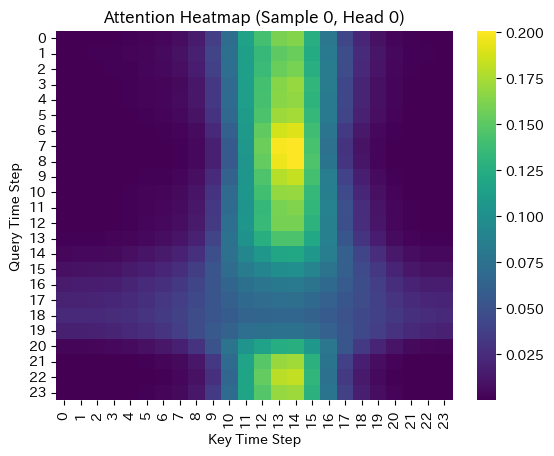

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(attn_scores[0, 0], cmap='viridis')
plt.title("Attention Heatmap (Sample 0, Head 0)")
plt.xlabel("Key Time Step")
plt.ylabel("Query Time Step")
plt.show()


## 時系列予測における代表的な深層学習モデルの特徴

<img src="IMG_6097.jpg">